In [131]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_1samp 

In [132]:
QUALFILE = "ED_Main_Spring_2023_March+31,+2023_13.40.csv"
df_qual = pd.read_csv("..\data\{}".format(QUALFILE))

KEYFILE = "key.csv"
df_key = pd.read_csv("..\data\{}".format(KEYFILE))

In [133]:
df_qual

,RecordedDate,ID,session,Q1_1,Q1_2
0,Recorded Date,Thank you for participating in our study. Plea...,Enter test-session,Do you think the drink you just had contains c...,Do you think the drink you just had contains c...
1,"{""ImportId"":""recordedDate"",""timeZone"":""Europe/...","{""ImportId"":""QID21_TEXT""}","{""ImportId"":""QID14""}","{""ImportId"":""QID1211366423_1""}","{""ImportId"":""QID1211366423_2""}"
2,2023-02-15 11:58:54,NaN,1st test,6,4
3,2023-03-06 15:37:12,1111,1st test,8,8
4,2023-03-06 15:39:52,1111,1st test,8,8
...,...,...,...,...,...
214,2023-03-29 15:27:32,3054,3rd test,3,10
215,2023-03-29 15:28:03,3048,3rd test,4,6
216,2023-03-29 15:33:58,9085,3rd test,7,9
217,2023-03-29 15:35:04,9245,3rd test,2,3


In [134]:
df_key

,ID,T2,T3
0,2009,CS,CXS
1,2054,CS,CXS
2,3024,CS,CXS
3,4010,CS,CXS
4,5052,CS,CXS
...,...,...,...
67,6080,DCXS,CS
68,7084,DCXS,CS
69,7096,DCXS,CS
70,7108,DCXS,CS


In [146]:
# Attention! If we look at T1 as well we will have to make some adjustments to ID numbers - see osf wiki

In [135]:
# tidying up dataframe by renaming columns and replacing session names
df_qual.rename(columns={"Q1_1": "caffeine", "Q1_2": "sugar"}, inplace=True)
df_qual.replace({"1st test": "T1", "2nd test": "T2", "3rd test": "T3"}, inplace=True)

In [136]:
# drop 2018 because did not get a drink on T2
idx = df_key[df_key.ID == 2018].index
df_key.drop(idx, inplace=True)

In [137]:
# removes all rows from qualtrics data that donåt have a matching ID in keys.csv
IDs = [str(id) for id in df_key.ID.unique()]
df_qual = df_qual.query("ID in @IDs")

In [138]:
print("The number of T1 rows is {}.".format(sum(df_qual.session == "T1")))
print("The number of T2 rows is {}.".format(sum(df_qual.session == "T2")))
print("The number of T3 rows is {}.".format(sum(df_qual.session == "T3")))

The number of T1 rows is 71.
The number of T2 rows is 65.
The number of T3 rows is 61.


In [139]:
# converts scores for caffeine and sugar to integers
df_qual.caffeine = df_qual.caffeine.astype(int)
df_qual.sugar = df_qual.sugar.astype(int)

C:\Users\jmc010\AppData\Local\Temp\ipykernel_14172\1144578672.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_qual.caffeine = df_qual.caffeine.astype(int)
C:\Users\jmc010\AppData\Local\Temp\ipykernel_14172\1144578672.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_qual.sugar = df_qual.sugar.astype(int)


In [140]:
# reformats key.csv so it can be merged with qualtrics data
df_key_long = pd.wide_to_long(df_key, "T", i="ID", j="session")
df_key_long.reset_index(inplace=True)
df_key_long["session"] = ["T{}".format(s) for s in df_key_long.session]
df_key_long.ID = [str(id) for id in df_key_long.ID]
df_key_long.rename(columns={"T": "condition"}, inplace=True)

In [141]:
# adds column for condition (e.g. CS, DCS etc) by merging two dfs
df_qual = df_qual.merge(df_key_long, on=["ID", "session"])

In [143]:
df_qual.ID.nunique()

65

In [169]:
# function to get difference scores
def get_diff_scores(df, conditions, value):
    df_reduced = df.query("condition in @conditions")
    
    df_diff = pd.pivot(df_reduced, index="ID", columns="condition", values=value)
    df_diff["difference_score"] = df_diff[conditions[0]] - df_diff[conditions[1]]
        
    df_diff = df_diff[~pd.isna(df_diff["difference_score"])]
    
    return df_diff
   
conditions = ["CS", "DCS"]
df_caffeine = get_diff_scores(df_qual, conditions, "caffeine")
df_caffeine_sug = get_diff_scores(df_qual, conditions, "sugar")

conditions = ["CS", "CXS"]
df_sugar = get_diff_scores(df_qual, conditions, "sugar")
df_sugar_caff = get_diff_scores(df_qual, conditions, "caffeine")


conditions = ["CS", "DCXS"]
df_both_caff = get_diff_scores(df_qual, conditions, "caffeine")
df_both_sug = get_diff_scores(df_qual, conditions, "sugar")


In [145]:
print("The number of subjects with CS vs DCS is {}".format(len(df_caffeine)))
print("The number of subjects with CS vs CXS is {}".format(len(df_sugar)))
print("The number of subjects with CS vs DCXS is {}".format(len(df_both_caff)))

The number of subjects with CS vs DCS is 18
The number of subjects with CS vs CXS is 20
The number of subjects with CS vs DCXS is 23


In [147]:
df_caffeine

condition,CS,DCS,difference_score
ID,,,
2036,6.0,6.0,0.0
3012,7.0,4.0,3.0
3048,4.0,4.0,0.0
4025,3.0,4.0,-1.0
4030,7.0,7.0,0.0
4035,7.0,7.0,0.0
4050,7.0,7.0,0.0
6024,8.0,7.0,1.0
6032,5.0,6.0,-1.0


In [156]:
res = ttest_1samp(df_both_sug.difference_score, 0)

if res.pvalue > 0.05:
    print("The difference scores are not different from zero, p = {:.3f}".format(res.pvalue))
else:
    print("The difference scores are different from zero, p = {:.3f}".format(res.pvalue))
    
ci = res.confidence_interval()

The difference scores are not different from zero, p = 0.327


Text(0.5, 0, 'Contains caffeine (CS - DCS)')

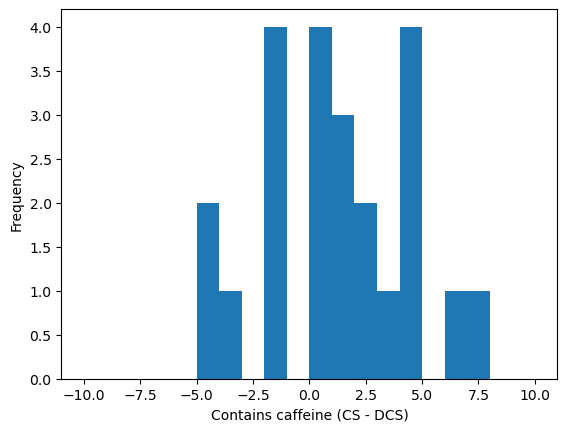

In [163]:
bins = range(-10, 11)

f, ax = plt.subplots()

ax.hist(df_both_caff.difference_score, bins=bins)
ax.set_ylabel("Frequency")
ax.set_xlabel("Contains caffeine (CS - DCS)")


Text(0.5, 0, 'Contains sugar (CS - DCXS)')

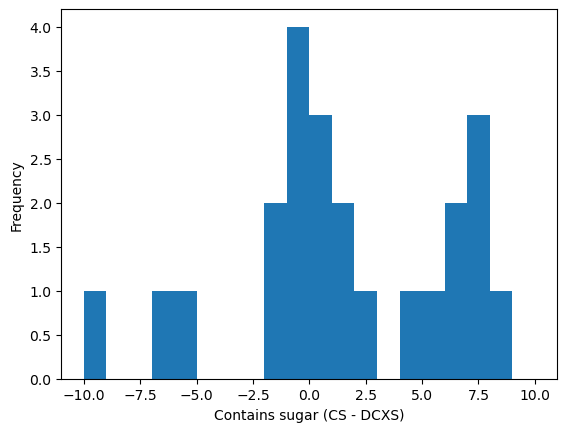

In [161]:
bins = range(-10, 11)

f, ax = plt.subplots()

ax.hist(df_both_sug.difference_score, bins=bins)
ax.set_ylabel("Frequency")
ax.set_xlabel("Contains sugar (CS - DCXS)")

Text(10, 6, 'CS - DCXS')

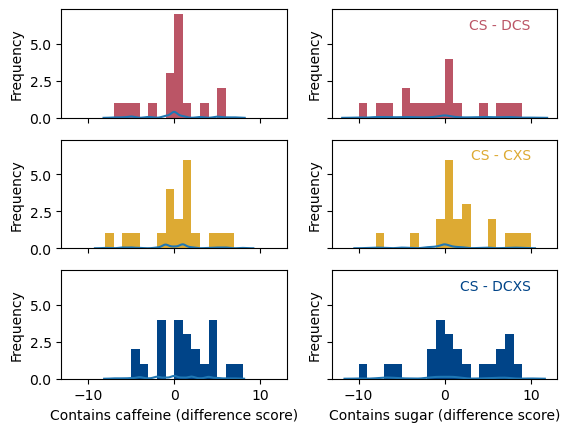

In [200]:
def make_difference_hist(df, bins, axis, color="red"):
    axis.hist(df.difference_score, bins=bins, color=color)
    axis.set_ylabel("Frequency")
    # axis.set_xlabel("Contains sugar (CS - DCXS)")
    
    rnd_array = []
    for n in range(100):
        rnd_array.append(df.difference_score.apply( lambda x : x * random.choice([-1,1])).values)

    sns.kdeplot(np.array(tp.flatten_list(rnd_array)*len(df), ax=axis)
        
#     axis.hist(rnd, bins=bins, color="grey")
    
    

cs_dcs_color = "#BB5566"
cs_cxs_color = "#DDAA33"
cs_dcxs_color = "#004488"
    
f, ax = plt.subplots(nrows=3, ncols=2, sharex=True, sharey=True)

make_difference_hist(df_caffeine, bins, ax[0,0], color=cs_dcs_color)
make_difference_hist(df_caffeine_sug, bins, ax[0,1], color=cs_dcs_color)

make_difference_hist(df_sugar, bins, ax[1,1], color=cs_cxs_color)
make_difference_hist(df_sugar_caff, bins, ax[1,0], color=cs_cxs_color)

make_difference_hist(df_both_caff, bins, ax[2,0], color=cs_dcxs_color)
make_difference_hist(df_both_sug, bins, ax[2,1], color=cs_dcxs_color)

ax[2,0].set_xlabel("Contains caffeine (difference score)")
ax[2,1].set_xlabel("Contains sugar (difference score)")

ax[0,1].text(10,6,"CS - DCS", horizontalalignment="right", color=cs_dcs_color)
ax[1,1].text(10,6,"CS - CXS", horizontalalignment="right", color=cs_cxs_color)
ax[2,1].text(10,6,"CS - DCXS", horizontalalignment="right", color=cs_dcxs_color)



In [33]:
import random

In [195]:
rnd_array = []
for n in range(100):
    rnd_array.append(df_both_sug.difference_score.apply( lambda x : x * random.choice([-1,1])).values)


In [203]:
len(df_both_sug)

23

<Axes: ylabel='Density'>

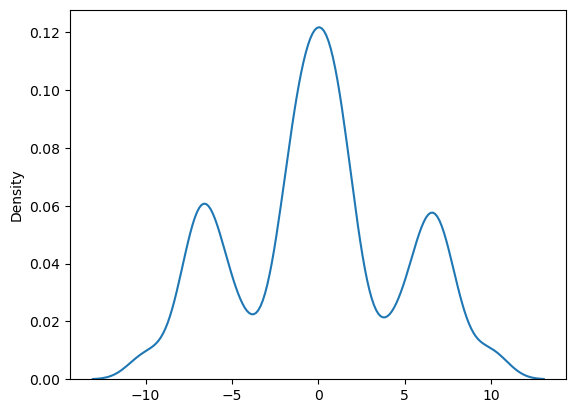

In [204]:
import seaborn as sns
import trompy as tp
rnd_array
sns.kdeplot(tp.flatten_list(rnd_array), weights=23)

In [57]:
df_caffeine.difference_score

ID
2018    6.0
2036    0.0
3012    3.0
3048    0.0
4025   -1.0
4030    0.0
4035    0.0
4050    0.0
6024    1.0
6032   -1.0
7024   -6.0
7036   -7.0
7048   -3.0
8014    0.0
8021    5.0
8042    0.0
9034    5.0
9245   -1.0
Name: difference_score, dtype: float64